In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from iminuit import minuit
from iminuit.cost import LeastSquares


In [3]:
%load_ext autoreload
%autoreload 2

rc('text', usetex=False)
rc('font', family='serif', size=20)
rc('figure', figsize=(12,8))
rc('axes',linewidth=2)

In [4]:
import sys
sys.path.append('/home/drtofa/OneDrive/QTLab2324/DATA ANALYSIS')
from UTILS.Trigger import  exponential_moving_average

In [43]:
with h5py.File('/home/drtofa/OneDrive/QTLab2324/DATA ANALYSIS/RUN_10_PULSE_999.hdf5','r') as hdf5:
    I = hdf5['Signals']['I']
    temp = I[:]
    I = I[:np.argmin(I)+129000]
    test = I
    #test = exponential_moving_average(I, 180)
    test = -1*((test-max(test)))/max(-1*(test-max(test)))
    test -= test[:40000].mean()

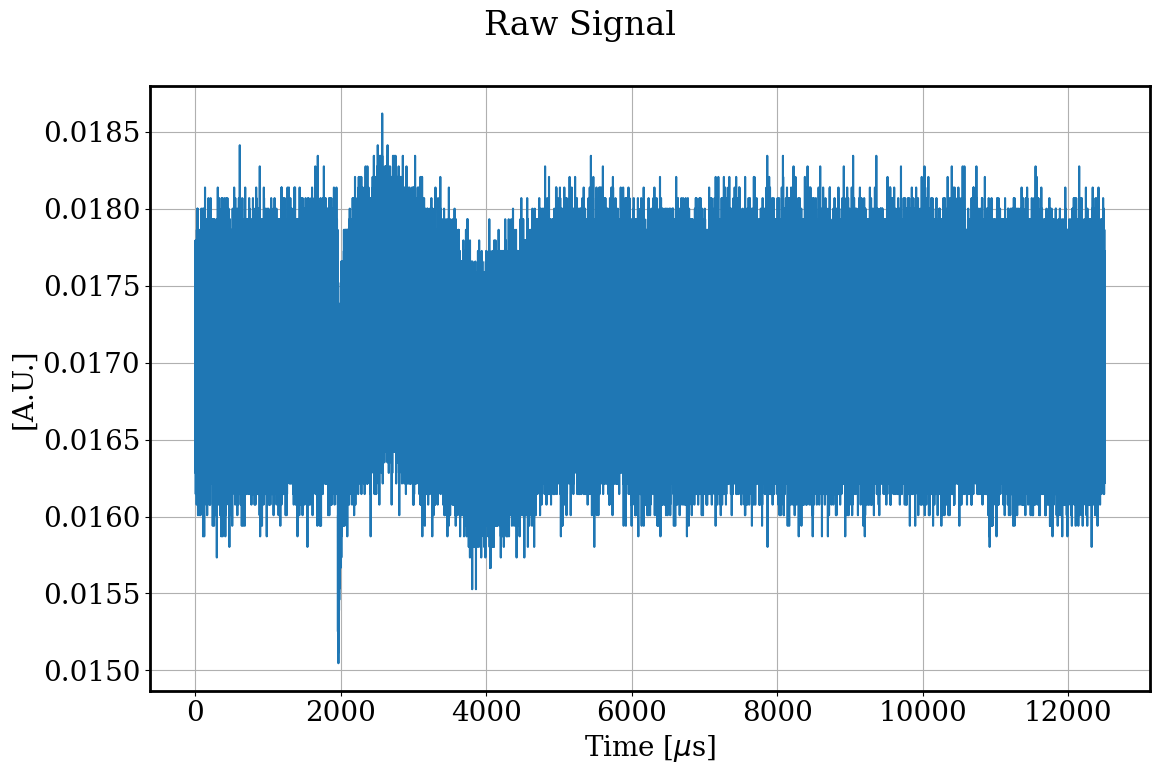

In [45]:
fig, axs = plt.subplots()
axs.plot(np.linspace(0,len(temp),len(temp))*1e-8/1e-6,temp)
axs.grid()
axs.set_xlabel('Time [$\mu$s]')
axs.set_ylabel('[A.U.]')
fig.suptitle('Raw Signal')
fig.tight_layout()

In [27]:
print(f'SNR : {max(test)/np.sqrt(np.sum(test**2)):.5f}')

SNR : 0.00641


In [331]:
data = np.genfromtxt('/home/drtofa/OneDrive/QTLab2324/DATA ANALYSIS/OPTIMUM/TXT/medium.txt')
data /= data.max()

Text(0.5, 0, 'Tims [$\\mu$s]')

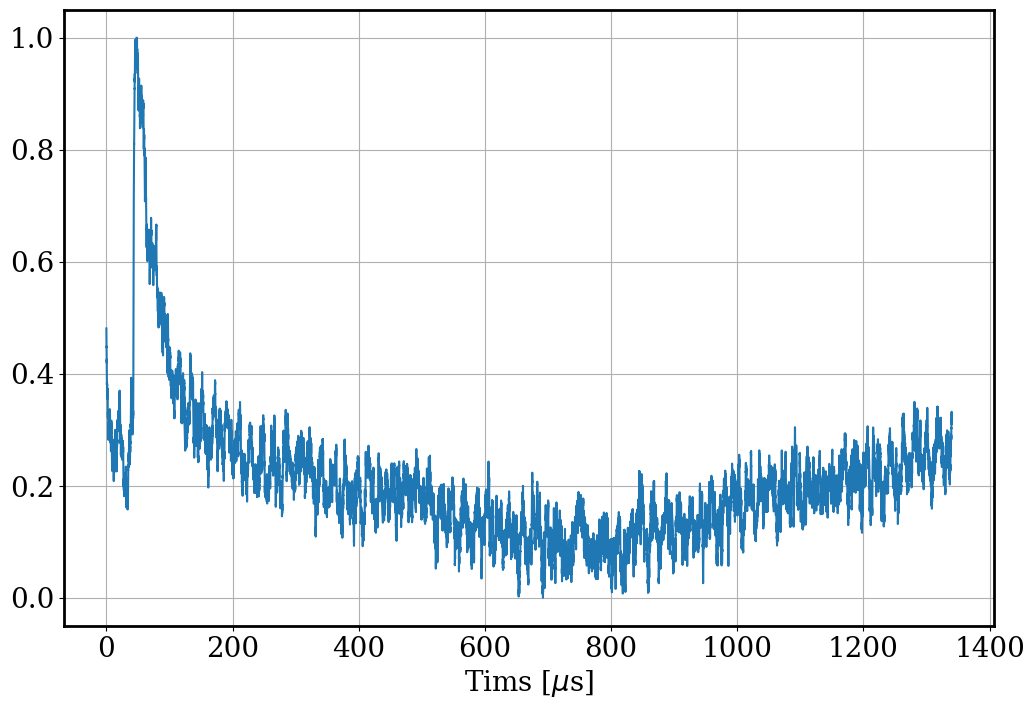

In [332]:
fig, axs = plt.subplots()
axs.plot(np.linspace(0,test.shape[0],test.shape[0])*1e-8/1e-6,test)
axs.grid()
axs.set_xlabel('Tims [$\mu$s]')

In [315]:
rms = np.sqrt(np.sum(data[:800]**2))
dev = data[:800].std()

rms_test = np.sqrt(np.sum(test[:800]**2))
dev_test = test[:800].std()

In [316]:
def double_exp(t, A, t0, taur, taud,k):
    x = A*(1-np.exp(-(t-t0)/taur))*np.exp(-(t-t0)/taud)+k
    return np.maximum(x, 0)

def multiple_exp(t, A, t0, taur, B1, taud1, B2, taud2, t1,k):
    x = A*(1-np.exp(-(t-t0)/taur))*(B1*np.exp(-(t-t0)/taud1) + B2*np.exp(-(t-t1)/taud2))+k
    return np.maximum(x, 0)

In [317]:
x = np.linspace(0,data.shape[0],data.shape[0])
p0 = [1.2, 980, 180, 3650, data[17500:].min()]
p1 = [1.2, 3000, 180, 0.6, 3650, 0.45, 1000, 1000,data[17500:].min()]

In [318]:
lsq = LeastSquares(x,data,dev,double_exp)
m= minuit.Minuit(lsq, *p0)
m.migrad();

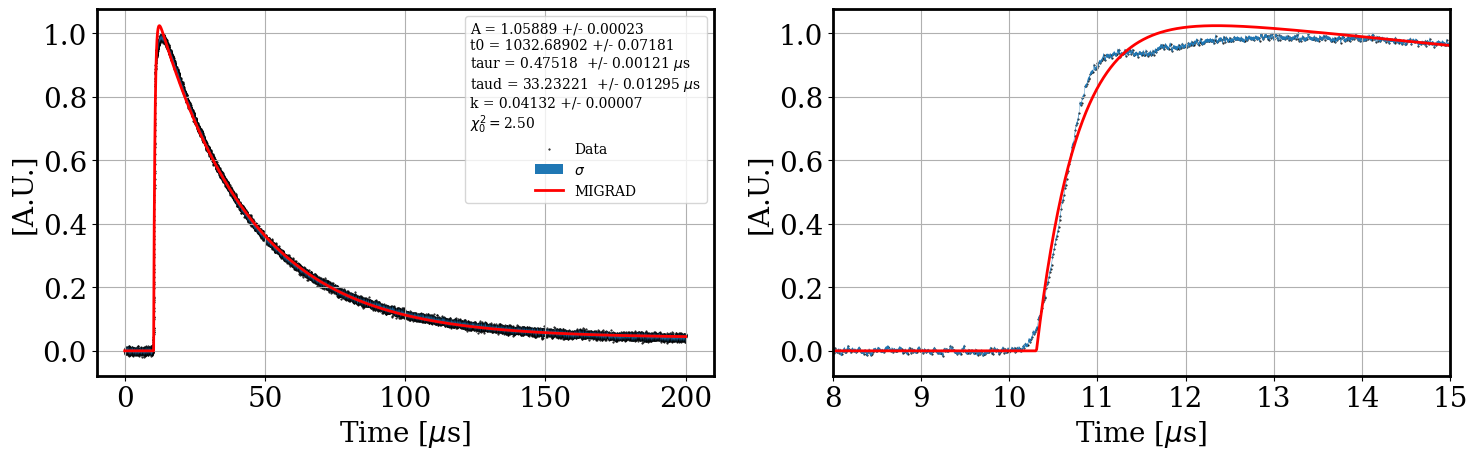

In [319]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(x*1e-2,data,s=1,marker='.',label='Data',color='black')
axs[0].fill_between(x*1e-2,data-dev,data+dev,label=r'$\sigma$')
axs[0].plot(x*1e-2,double_exp(x,*m.values),linewidth=2,color='red',label='MIGRAD')
axs[0].grid()
axs[0].set_ylabel('[A.U.]')
axs[0].set_xlabel(r'Time [$\mu$s]')

axs[1].scatter(x*1e-2,data,s=1,marker='.',label='Data',color='black')
axs[1].fill_between(x*1e-2,data-dev,data+dev,label=r'$\sigma$')
axs[1].plot(x*1e-2,double_exp(x,*m.values),linewidth=2,color='red',label='MIGRAD')
axs[1].grid()
axs[1].set_ylabel('[A.U.]')
axs[1].set_xlabel(r'Time [$\mu$s]')
axs[1].set_xlim([800*1e-2,1500*1e-2])

title = []
for par in m.parameters:
    if 'tau'  in par:
        title.append(
            fr"{par} = {m.values[par]*1e-2:.5f}  +/- {m.errors[par]*1e-2:.5f} $\mu$s"
        )
    else:
        title.append(
            fr"{par} = {m.values[par]:.5f} +/- {m.errors[par]:.5f}"
        )
title.append(r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof:.2f}")

# Create the legend
legend = axs[0].legend(title="\n".join(title),fontsize=10)

# Adjust the title's font size
legend.get_title().set_fontsize(10)  # or use a numeric value like 8
fig.tight_layout()

In [320]:
x1 = np.linspace(0,test.shape[0],test.shape[0])
lsq1 = LeastSquares(x1,test,dev_test,multiple_exp)
m1 = minuit.Minuit(lsq1, *p1)
m1.migrad();

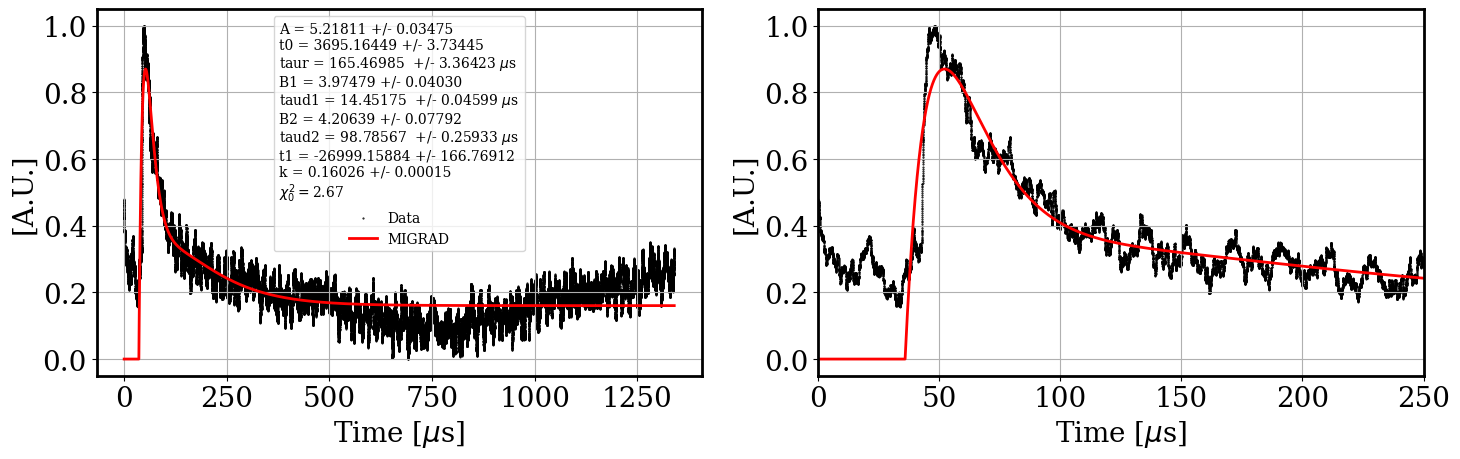

In [321]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(x1*1e-2,test,s=1,marker='.',label='Data',color='black')
#axs[0].fill_between(x1*1e-2,test-dev_test,test+dev_test,label=r'$\sigma$')
axs[0].plot(x1*1e-2,multiple_exp(x1,*m1.values),linewidth=2,color='red',label='MIGRAD')
axs[0].grid()
axs[0].set_ylabel('[A.U.]')
axs[0].set_xlabel(r'Time [$\mu$s]')

axs[1].scatter(x1*1e-2,test,s=1,marker='.',label='Data',color='black')
#axs[1].fill_between(x1*1e-2,test-dev_test,test+dev_test,label=r'$\sigma$')
axs[1].plot(x1*1e-2,multiple_exp(x1,*m1.values),linewidth=2,color='red',label='MIGRAD')
axs[1].grid()
axs[1].set_ylabel('[A.U.]')
axs[1].set_xlabel(r'Time [$\mu$s]')
axs[1].set_xlim([0,250])

title = []
for par in m1.parameters:
    if 'tau'  in par:
        title.append(
            fr"{par} = {m1.values[par]*1e-2:.5f}  +/- {m1.errors[par]*1e-2:.5f} $\mu$s"
        )
    else:
        title.append(
            fr"{par} = {m1.values[par]:.5f} +/- {m1.errors[par]:.5f}"
        )
title.append(r'$\chi^{2}_{0} = $'+f"{m1.fval/m1.ndof:.2f}")

# Create the legend
legend = axs[0].legend(title="\n".join(title),fontsize=10)

# Adjust the title's font size
legend.get_title().set_fontsize(10)  # or use a numeric value like 8
fig.tight_layout()

In [322]:
print(f"Decay constant : {m.values['taud']*1e-8/1e-6} +/- {m.errors['taud']*1e-8/1e-6}")
print(f"Rise  constant : {m.values['taur']*1e-8/1e-6} +/- {m.errors['taur']*1e-8/1e-6}")


Decay constant : 33.23220539217824 +/- 0.012946728415519864
Rise  constant : 0.4751753876930683 +/- 0.0012112593887060336


In [323]:
lsq = LeastSquares(x,data,dev,multiple_exp)
m = minuit.Minuit(lsq, *p1)
m.migrad();

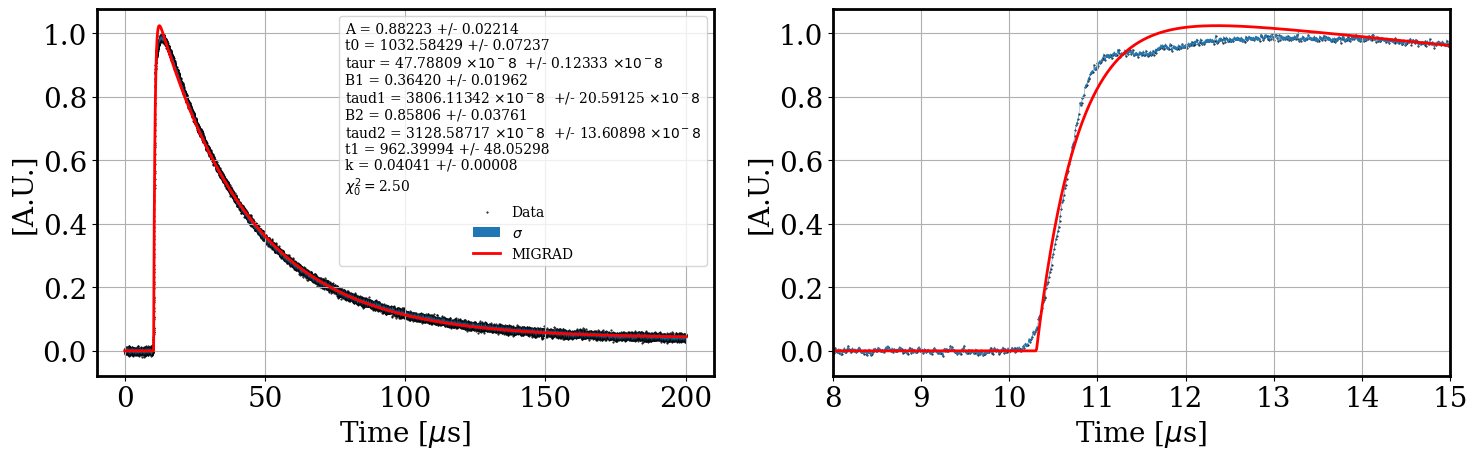

In [324]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(x*1e-2,data,s=1,marker='.',label='Data',color='black')
axs[0].fill_between(x*1e-2,data-dev,data+dev,label=r'$\sigma$')
axs[0].plot(x*1e-2,multiple_exp(x,*m.values),linewidth=2,color='red',label='MIGRAD')
axs[0].grid()
axs[0].set_ylabel('[A.U.]')
axs[0].set_xlabel('Time [$\mu$s]')

axs[1].scatter(x*1e-2,data,s=1,marker='.',label='Data',color='black')
axs[1].fill_between(x*1e-2,data-dev,data+dev,label=r'$\sigma$')
axs[1].plot(x*1e-2,multiple_exp(x,*m.values),linewidth=2,color='red',label='MIGRAD')
axs[1].grid()
axs[1].set_ylabel('[A.U.]')
axs[1].set_xlabel('Time [$\mu$s]')
axs[1].set_xlim([8,15])

title = []
for par in m.parameters:
    if 'tau'  in par:
        title.append(
            fr"{par} = {m.values[par]:.5f} $\times 10^{-8}$  +/- {m.errors[par]:.5f} $\times 10^{-8}$"
        )
    else:
        title.append(
            fr"{par} = {m.values[par]:.5f} +/- {m.errors[par]:.5f}"
        )
title.append(r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof:.2f}")

# Create the legend
legend = axs[0].legend(title="\n".join(title),fontsize=10)

# Adjust the title's font size
legend.get_title().set_fontsize(10)  # or use a numeric value like 8
fig.tight_layout()